In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset, WeightedRandomSampler, SubsetRandomSampler, random_split
from PIL import Image

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

 99% 778M/786M [00:09<00:00, 81.3MB/s]
100% 786M/786M [00:09<00:00, 86.3MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Kaggle/skin-cancer9-classesisic.zip

In [ ]:
path = '/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration'


In [ ]:
train_path = path + '/Train'
test_path = path + '/Test'

In [ ]:
from pathlib import Path
train_dir = Path(train_path)
test_dir = Path(test_path)

In [ ]:
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepaths))


test_filepaths = list(test_dir.glob(r'**/*.jpg'))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

In [ ]:
len(train_filepaths), len(test_filepaths)

(2239, 118)

<Axes: >

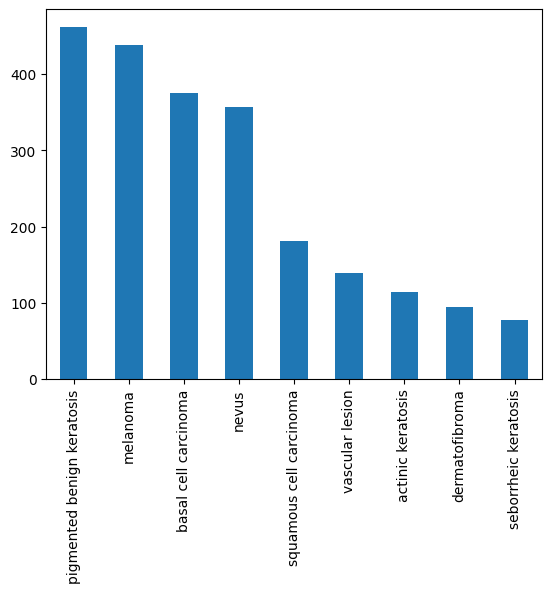

In [ ]:
train_filepaths = pd.Series(train_filepaths, name='path').astype(str)
train_labels = pd.Series(train_labels, name='Label')

train_df = pd.concat([train_filepaths, train_labels], axis=1)

train_df['Label'].value_counts().plot(kind = 'bar')

<Axes: >

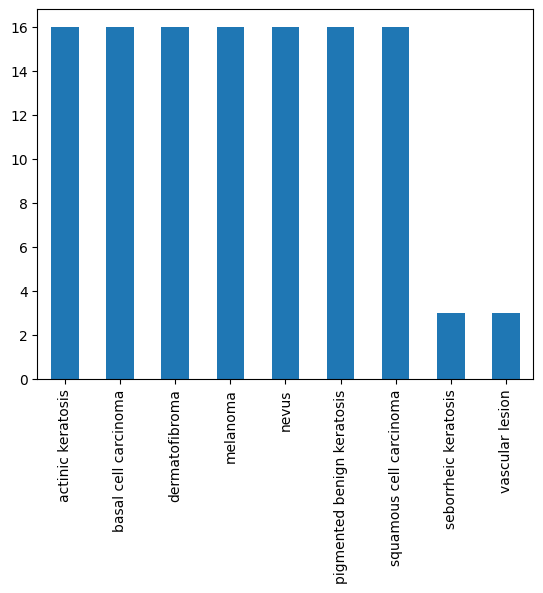

In [ ]:
test_filepaths = pd.Series(test_filepaths, name='path').astype(str)
test_labels = pd.Series(test_labels, name='Label')

test_df = pd.concat([test_filepaths, test_labels], axis=1)

test_df['Label'].value_counts().plot(kind = 'bar')

In [ ]:
unique_classes = list(train_df['Label'].unique())


In [ ]:
unique_classes

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
train_df

,path,Label
0,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,actinic keratosis
1,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,actinic keratosis
2,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,actinic keratosis
3,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,actinic keratosis
4,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,actinic keratosis
...,...,...
2234,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,vascular lesion
2235,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,vascular lesion
2236,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,vascular lesion
2237,/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC...,vascular lesion


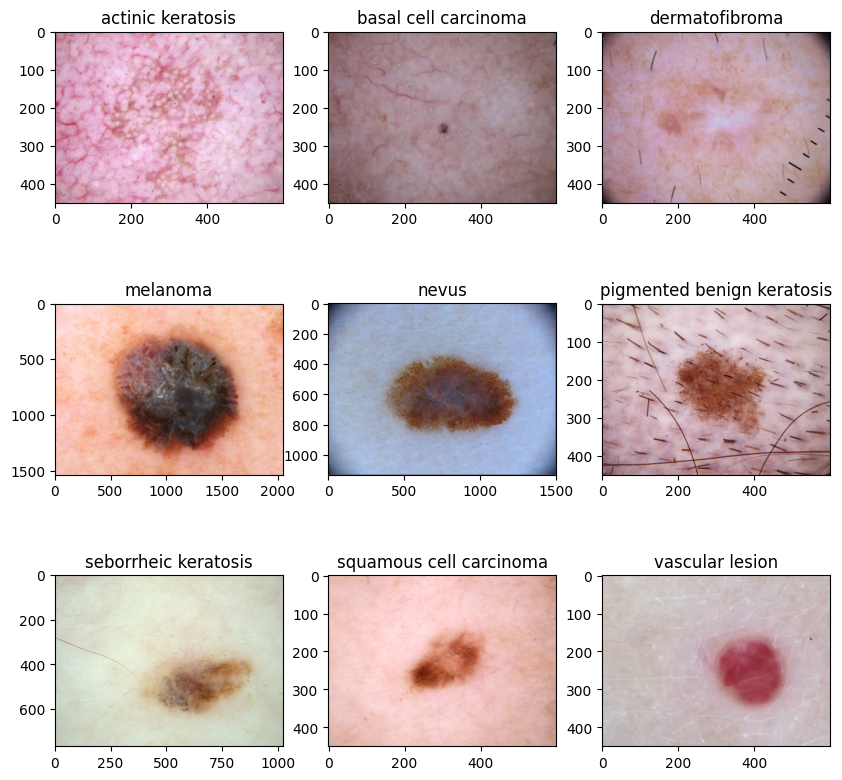

In [ ]:
num_classes = len(unique_classes)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(train_dir.glob(unique_classes[i]+'/*.jpg'))[1]))
  plt.title(unique_classes[i])
  plt.imshow(image)

**BALANCING DATASET BY OVERSAMPLING MINORITY CLASSES USING AUGMENTOR**

In [ ]:
#Class Imbalance
!pip install Augmentor



In [ ]:
import Augmentor

In [ ]:
path_to_train = path + '/Train/'

In [ ]:
#Run this cell to augment data and generate samples

# for cls in unique_classes:
#     print(cls)
#     p = Augmentor.Pipeline(path_to_train + cls, path + '/output/' + cls)
#     p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#     p.sample(1000)

In [ ]:
train_dir

PosixPath('/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train')

In [ ]:
augment_dir = Path(path + '/output')
image_count_train = len(list(augment_dir.glob(r'**/*.jpg')))
print(image_count_train)
augment_dir

9000


PosixPath('/content/drive/MyDrive/Kaggle/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/output')

total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

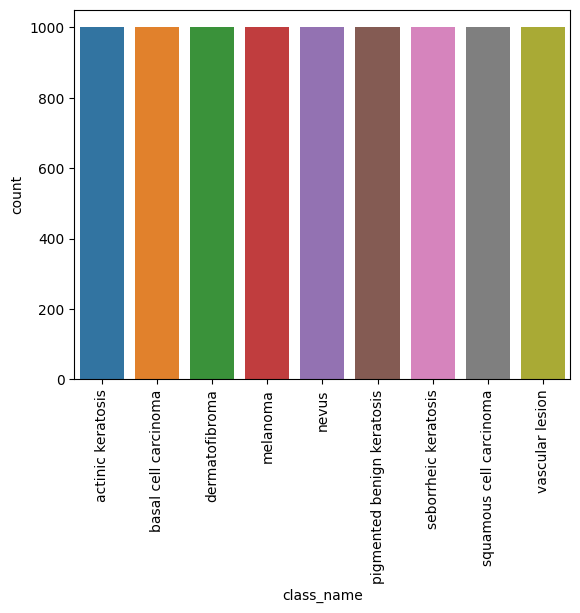

In [ ]:
num_classes = len(unique_classes)
total = 0
all_count = []
class_name = []

print("total training image count = {} \n".format(image_count_train))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(augment_dir.glob(unique_classes[i]+'/*.jpg')))
  print("Class name = ",unique_classes[i])
  print("count      = ",count)
  print("proportion = ",count/image_count_train)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(unique_classes[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

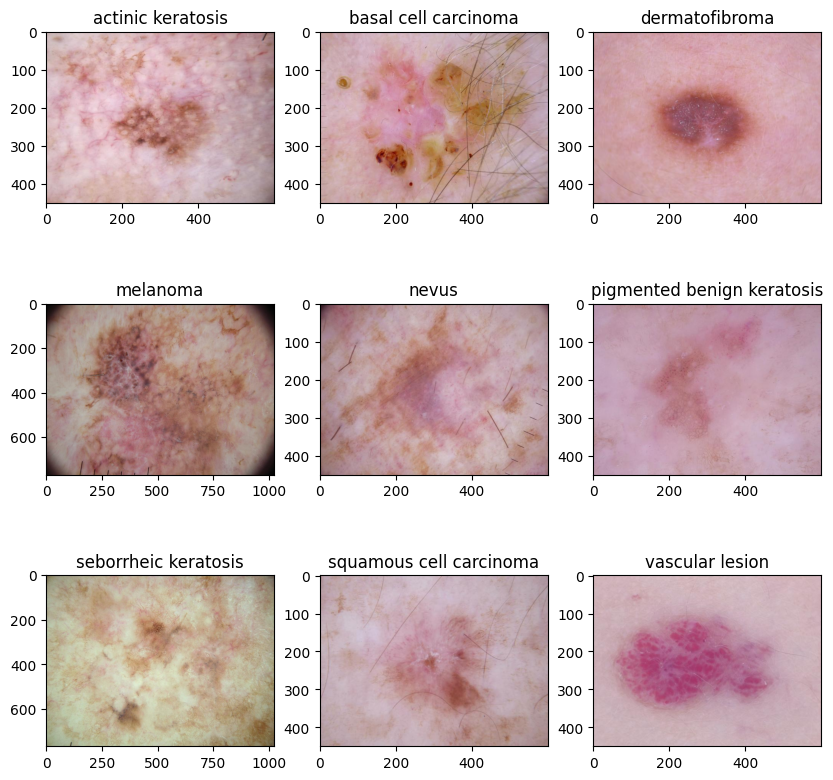

In [ ]:
#Visualizing augmented images

plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(augment_dir.glob(unique_classes[i]+'/*.jpg'))[1]))
  plt.title(unique_classes[i])
  plt.imshow(image)

**Splitting folder into train and validation 80-20**

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(path + '/output', output= path, seed=1337, ratio=(.8, 0.2))

Copying files: 9000 files [04:06, 36.51 files/s] 


**Applying Data Transformations**

In [ ]:
transformers = {'train' : transform.Compose([
    transform.Resize((224,224)),
    transform.RandomHorizontalFlip(),
    transform.RandomVerticalFlip(),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
                'Test': transform.Compose([
    transform.Resize((224,224)),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
                'val': transform.Compose([
    transform.Resize((224,224)),
    transform.CenterCrop(224),
    transform.ToTensor(),
    transform.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

Now, we need to take the slightly augmented data, split into train and valid sets and the test data separately

In [ ]:
new_train_path = path + '/train'
new_val_path = path + '/val'

In [ ]:
test_path = path + '/Test'

In [ ]:
image_datasets = {x: torchvision.datasets.ImageFolder(os.path.join(path, x),
                                          transformers[x])
                  for x in ['train', 'val', 'Test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'Test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'Test']}
class_names = image_datasets['train'].classes



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 146MB/s]


In [ ]:
# Freezing all the layers
for param in model.parameters():
  param.requires_grad = False

# Changing the Classifier
num_features = model.fc.in_features
model.fc = nn.Sequential(nn.Linear(num_features,len(unique_classes)))

# Making the Classifier layer Trainable
for param in model.fc.parameters():
  param.requires_grad = True

# Moving the model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer  = torch.optim.Adam(model.classifier.parameters(),lr = 0.01, weight_decay=1e-3)
optimizer  = torch.optim.Adam(model.parameters(),lr = 0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)



            if phase == 'train':
                scheduler.step()

            #For graph generation
            if phase == "train":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)

            if phase == "val":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model, criterion, optimizer, scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 1.1887 Acc: 0.6049
val Loss: 1.1770 Acc: 0.6072

Epoch 2/25
----------
train Loss: 1.1707 Acc: 0.6189
val Loss: 1.1290 Acc: 0.6411

Epoch 3/25
----------
train Loss: 1.2249 Acc: 0.6117
val Loss: 0.9716 Acc: 0.6783

Epoch 4/25
----------
train Loss: 1.1835 Acc: 0.6307
val Loss: 0.9388 Acc: 0.6806

Epoch 5/25
----------
train Loss: 1.1086 Acc: 0.6493
val Loss: 0.9084 Acc: 0.7139

Epoch 6/25
----------
train Loss: 1.1036 Acc: 0.6492
val Loss: 1.0677 Acc: 0.6439

Epoch 7/25
----------
train Loss: 1.1001 Acc: 0.6557
val Loss: 1.2733 Acc: 0.6283

Epoch 8/25
----------
train Loss: 0.7902 Acc: 0.7247
val Loss: 0.7762 Acc: 0.7450

Epoch 9/25
----------
train Loss: 0.7360 Acc: 0.7335
val Loss: 0.7808 Acc: 0.7378

Epoch 10/25
----------
train Loss: 0.7382 Acc: 0.7325
val Loss: 0.7777 Acc: 0.7294

Epoch 11/25
----------
train Loss: 0.7336 Acc: 0.7364
val Loss: 0.7571 Acc: 0.7406

Epoch 12/25
----------
train Loss: 0.7326 Acc: 0.7390
val Loss: 0.7326 Acc: 0.7478

E

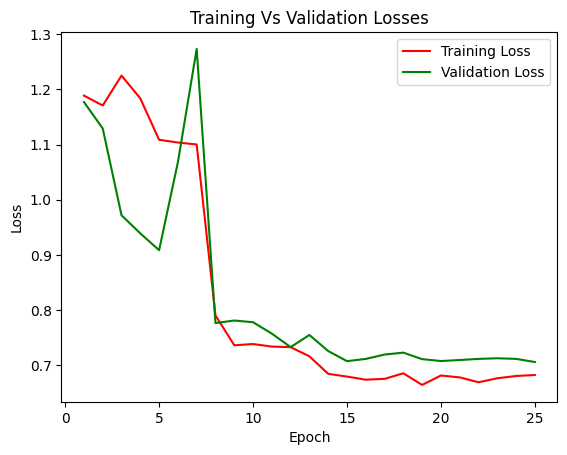

In [ ]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()


In [ ]:
#Test the accuracy with test data
correct = 0
total = 0
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 46 %


In [ ]:
#Class wise testing accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))
